# Práctica de Sistemas Recomendadores: Surprise - Funk's SVD

En este práctico implementaremos un recomendador basado en un algoritmo de factorización matricial propuesto por [Simon Funk](https://sifter.org/simon/journal/20061211.html).

Volveremos a utilizar la biblioteca de Surprise, desarrollada por Nicolas Hug.

**Profesor**: Denis Parra

**Ayudantes**: Alejandro Plaza y Daniel Sebastián

## Configuración inicial

Esta celda permite instalar una versión compatible de Numpy. Una vez que se pida reiniciar la sesión, no hay que volver a ejecutar esta celda.

In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.26

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 49.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.22.0 requires numpy>=1.26.0, but you have numpy 1.25.0 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.25.0 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.25.0 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.25.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.0 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.25.0 w

**Paso 1:** Descargue directamente a Colab los archivos del dataset ejecutando las siguientes 3 celdas:

In [1]:
!pip install gdown

In [2]:
!gdown 15Y164QnWdmus9QBHWBCwyYezMACZsx-h

Downloading...
From: https://drive.google.com/uc?id=15Y164QnWdmus9QBHWBCwyYezMACZsx-h
To: /content/u2.base
100% 1.58M/1.58M [00:00<00:00, 175MB/s]


In [3]:
!gdown 1lSlGE1daKvGqg6-nUcMzT9lJK66HPZEJ

Downloading...
From: https://drive.google.com/uc?id=1lSlGE1daKvGqg6-nUcMzT9lJK66HPZEJ
To: /content/u2.test
100% 395k/395k [00:00<00:00, 44.4MB/s]


In [4]:
!gdown 13afMOhZGgIKLz784biKbvZ1rnM4iJzLk

Downloading...
From: https://drive.google.com/uc?id=13afMOhZGgIKLz784biKbvZ1rnM4iJzLk
To: /content/u.item
100% 236k/236k [00:00<00:00, 118MB/s]


**Paso 2**: Instalamos Surprise utilizando `pip`.

In [5]:
!pip install scikit-surprise --no-build-isolation --no-deps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505913 sha256=9b219fe5071e5b08aabf7b20ee618552030a92bb1cfef4007dedfd6d94a39ace
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [6]:
import surprise
import numpy as np
import pandas as pd
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.25.2 and <2.6.0 is required for this version of SciPy (detected version 1.25.0)
  from scipy.stats import gaussian_kde


## Antes de recomendar

**Paso 3**: Los archivos `u2.base` y `u2.test` tienen tuplas (usuario, item, rating, timestamp), que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/). Revisemos cómo es uno de estos archivos y luego haremos gráficos que nos permitan sacar conclusiones a partir del mismo.

In [7]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [8]:
# Ahora queremos realizar una observación rápida de los datos
df_train.describe()

,userid,itemid,rating,timestamp
count,80000.000000,80000.000000,80000.000000,8.000000e+04
mean,494.508137,424.990487,3.526463,8.835467e+08
std,276.879511,330.564093,1.124429,5.379549e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,269.000000,174.000000,3.000000,8.794471e+08
50%,500.000000,321.000000,4.000000,8.828278e+08
75%,744.000000,630.000000,4.000000,8.884652e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


Por otra parte, para obtener información adicional de cada película tal como **título**, **fecha de lanzamiento**, **género**, etc., cargaremos el archivo de items descargado (`u.item`) para poder mapear cada identificador de ítem al conjunto de datos que lo describe. Revisemos el contenido de este archivo

In [9]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [10]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None,
                        encoding='latin-1')
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:
# Realizamos una inspección sobre estos datos (.info())
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musical    

In [12]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs
pelis = [5,4,1]
df_items.loc[pelis]['title']

,title
movieid,
5,Copycat (1995)
4,Get Shorty (1995)
1,Toy Story (1995)


**Paso 4:** Generemos algunos gráficos en relación a las películas.

/tmp/ipython-input-1823837166.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_count.values, y=genre_count.index, label="Total", palette="Blues_d")


<Axes: ylabel='None'>

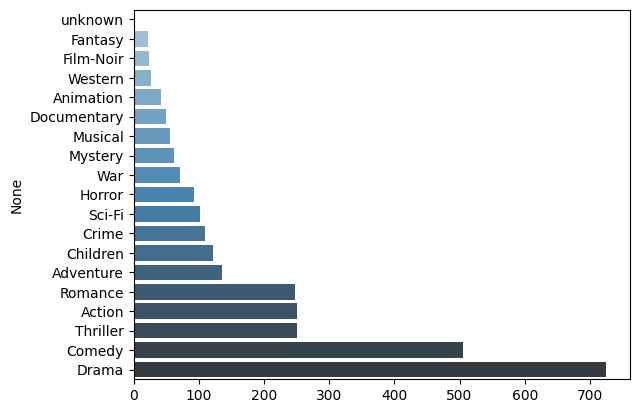

In [13]:
#Ignorar el warning
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

genre_count = df_items[genre_columns].sum().sort_values()

sns.barplot(x=genre_count.values, y=genre_count.index, label="Total", palette="Blues_d")

Antes de trabajar con SVD, responda las siguientes preguntas.

**Pregunta (2pto):** Explique cómo funciona SVD (como modelo, no piense en la implementación).





**Respuesta:** *COMPLETAR*

## SVD

**Paso 5**: Debemos convertir los datos para que sean soportados por la librería Surprise

In [14]:
from surprise.model_selection import PredefinedKFold
reader = surprise.Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1,5))
data = surprise.Dataset.load_from_folds([("u2.base", "u2.test")], reader=reader)
pkf = PredefinedKFold()
trainset, testset = next(pkf.split(data))


**Paso 6**: Tome un usuario, cualquiera, del dataset y reporte parte de sus gustos explícitamente (es decir, nombre de las películas, género, etc., no id). Para este mismo usuario, revise explícitamente las recomendaciones al llegar a la parametrización que reporta las mejores métricas.

In [15]:
user_id = 2
user_df = df_train[df_train['userid'] == user_id]

df_items.loc[user_df['itemid'].values]


,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
13,Mighty Aphrodite (1995),30-Oct-1995,NaN,http://us.imdb.com/M/title-exact?Mighty%20Aphr...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
19,Antonia's Line (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Antonia%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
237,Jerry Maguire (1996),13-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Jerry%20Magui...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
251,Shall We Dance? (1996),11-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Shall%20we%20...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
255,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
257,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [16]:
# Definicion de objeto svd
algorithm = SVD()
# Entrenamiento del modelo
algorithm.fit(trainset)

In [17]:
# Predicciones
predictions = algorithm.test(testset)

In [18]:
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.9374
MAE:  0.7363


0.7363015049768387

In [19]:
def get_top_n(predictions, n=10):
    """Devuelve las N-mejores recomendaciones para cada usuario de un set de predicción.

    Args:
        predictions(lista de objetos Prediction): La lista de predicción obtenida del método test.
        n(int): El número de recomendaciónes por usuario

    Returns:
    Un diccionario donde las llaves son ids de usuario y los valores son listas de tuplas:
        [(item id, rating estimation), ...] de tamaño n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [20]:
top_n = get_top_n(predictions, n=10)
print('Recommendation for user {}: {}'.format(user_id, top_n["2"]))

Recommendation for user 2: [('14', 4.248751261018604), ('242', 4.176067862937017), ('10', 4.051470400865917), ('1', 4.0205943972490585), ('293', 4.019442635406598), ('306', 3.8755967268343854), ('310', 3.7949198512920517), ('276', 3.7818648386586236), ('258', 3.7739283838003423), ('25', 3.763975400681405)]


Ver explícitamente las recomendaciones para un usuario

In [21]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

info_file = pd.read_csv('u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

info_file.loc[[int(m[0]) for m in top_n["2"]]]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
14,"Postino, Il (1994)",01-Jan-1994,NaN,"http://us.imdb.com/M/title-exact?Postino,%20Il...",0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
242,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10,Richard III (1995),22-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Richard%20III...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
293,Donnie Brasco (1997),28-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Donnie%20Bras...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
306,"Mrs. Brown (Her Majesty, Mrs. Brown) (1997)",01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Her+Majesty%2...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
310,"Rainmaker, The (1997)",01-Jan-1997,NaN,"http://us.imdb.com/M/title-exact?Rainmaker,+Th...",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
276,Leaving Las Vegas (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Leaving%20Las...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
258,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


**Paso 7 (10ptos):** Pruebe distintos valores de los parámetros de entrenamiento del algoritmo SVD:
- Número de factores (n_factors)
- Número de iteraciones máxima (n_epochs)
- Learning rate (lr_all)

Y hay muchos más que pueden probar.

Describa cómo estos afectan las métricas y las recomendaciones hechas para el usuario que escogió (2 ptos por cada combinación probada y comentada): *COMPLETAR*

**Paso 8:** Genere un gráfico explorando todos los parámetros que ofrece el modelo `SVD`, donde se grafiquen los valores probados para cada parámetro y el RMSE obtenido para cada uno. Debe probar una cantidad razonable de valores buscando la mejor parametrización y entregar el notebook con dicha parametrización.



In [22]:
# Ejemplo
factor_values = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for f in factor_values:
  algorithm = SVD(n_factors=f)
  algorithm.fit(trainset)
  predictions = algorithm.test(testset)
  mae = accuracy.mae(predictions)
  rmse = accuracy.rmse(predictions)

  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

MAE:  0.7390
RMSE: 0.9403
MAE:  0.7428
RMSE: 0.9447
MAE:  0.7409
RMSE: 0.9411
MAE:  0.7466
RMSE: 0.9476
MAE:  0.7485
RMSE: 0.9500
MAE:  0.7494
RMSE: 0.9539
MAE:  0.7539
RMSE: 0.9553
MAE:  0.7562
RMSE: 0.9585
MAE:  0.7547
RMSE: 0.9568
MAE:  0.7558
RMSE: 0.9580
[0.7389880794189677, 0.7428278552427362, 0.7408943915994141, 0.7465593387570094, 0.7484817831651259, 0.7494166901099001, 0.7538918494533393, 0.7562492921911517, 0.7546692302065476, 0.755771894894863]
[0.9403371540828185, 0.9447443754104333, 0.9411467330513144, 0.9475503464445607, 0.950023899751633, 0.9538560319080085, 0.9552544640173933, 0.9584888832946773, 0.9568192156248266, 0.9580051924245077]


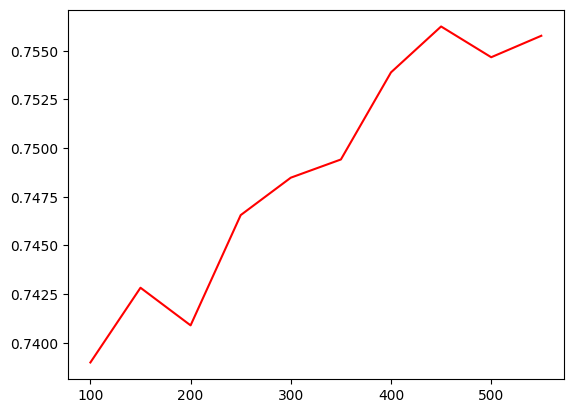

In [23]:
plt.plot(factor_values, mae_values, 'r-')
plt.show()

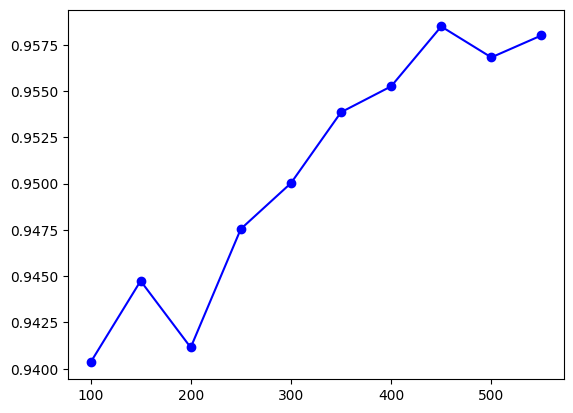

In [24]:
plt.plot(factor_values, rmse_values, 'bo-')
plt.show()

**Paso 9 (6 ptos):** Pruebe con otros valores y/o parámetros (mínimo 3 combinaciones. Se recomienda elegir entre las combinaciones del paso 7):

*COMPLETAR*